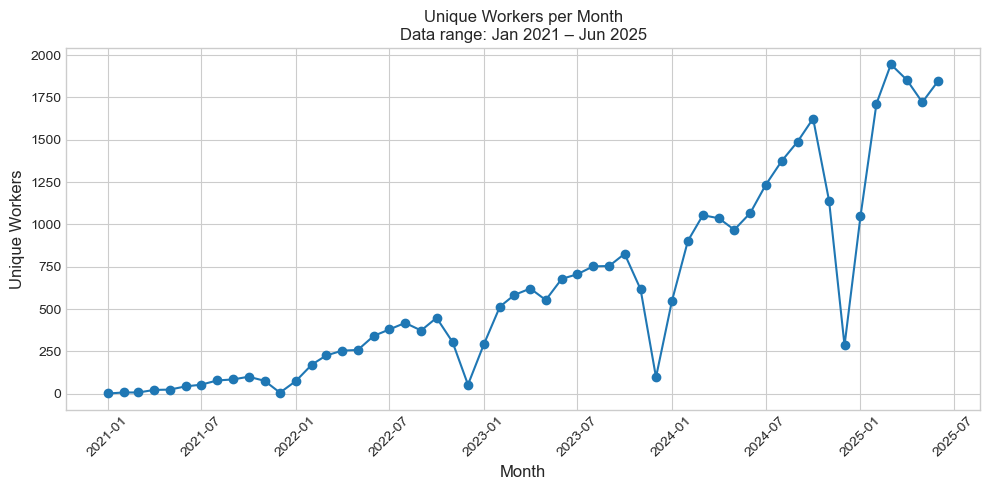

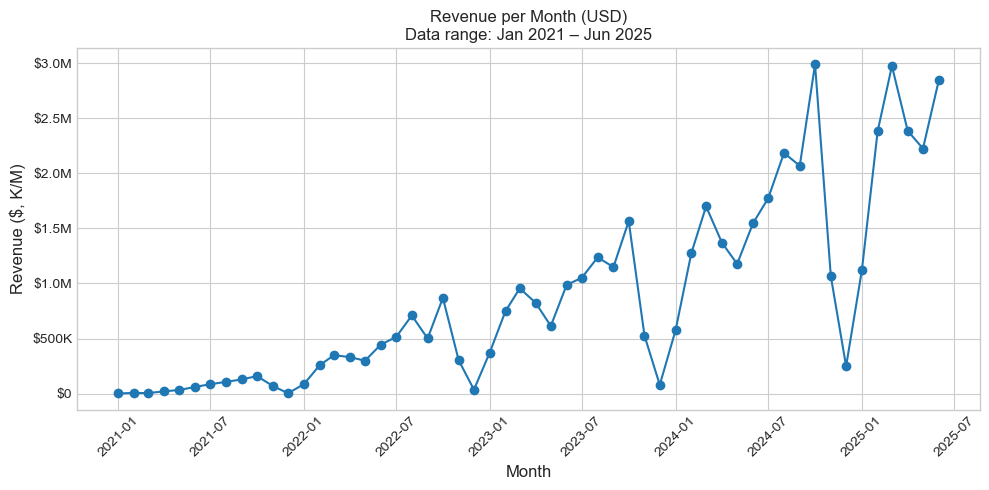

In [15]:

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

%matplotlib inline


file_path = "diligence_initech.fake_initech_worker_data.csv"
df = pd.read_csv(file_path)


df["month"] = pd.to_datetime(df["month"], errors="coerce")
df = df.dropna(subset=["month"])


monthly_metrics = (
    df
    .groupby(df["month"].dt.to_period("M"))
    .agg(
        unique_workers=("worker_id", "nunique"),
        revenue=("revenue", "sum")
    )
    .reset_index()
)

monthly_metrics["month"] = monthly_metrics["month"].dt.to_timestamp()
monthly_metrics = monthly_metrics.sort_values("month")


start_month = monthly_metrics["month"].min().strftime("%b %Y")
end_month = monthly_metrics["month"].max().strftime("%b %Y")


plt.figure(figsize=(10, 5))
plt.plot(
    monthly_metrics["month"],
    monthly_metrics["unique_workers"],
    marker="o"
)

plt.title(
    f"Unique Workers per Month\nData range: {start_month} – {end_month}"
)
plt.xlabel("Month")
plt.ylabel("Unique Workers")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

def revenue_formatter(x, pos):
    if x >= 1_000_000:
        return f"${x/1_000_000:.1f}M"
    elif x >= 1_000:
        return f"${x/1_000:.0f}K"
    else:
        return f"${x:.0f}"

plt.figure(figsize=(10, 5))
plt.plot(
    monthly_metrics["month"],
    monthly_metrics["revenue"],
    marker="o"
)

plt.gca().yaxis.set_major_formatter(FuncFormatter(revenue_formatter))

plt.title(
    f"Revenue per Month (USD)\nData range: {start_month} – {end_month}"
)
plt.xlabel("Month")
plt.ylabel("Revenue ($, K/M)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Loaded: diligence_initech.fake_initech_worker_data.csv shape: (34968, 5)
Using user id column: worker_id
Saved cohort retention table (percent) to: cohort_retention_table.csv
Cohorts: 53 months tracked (cols): 25


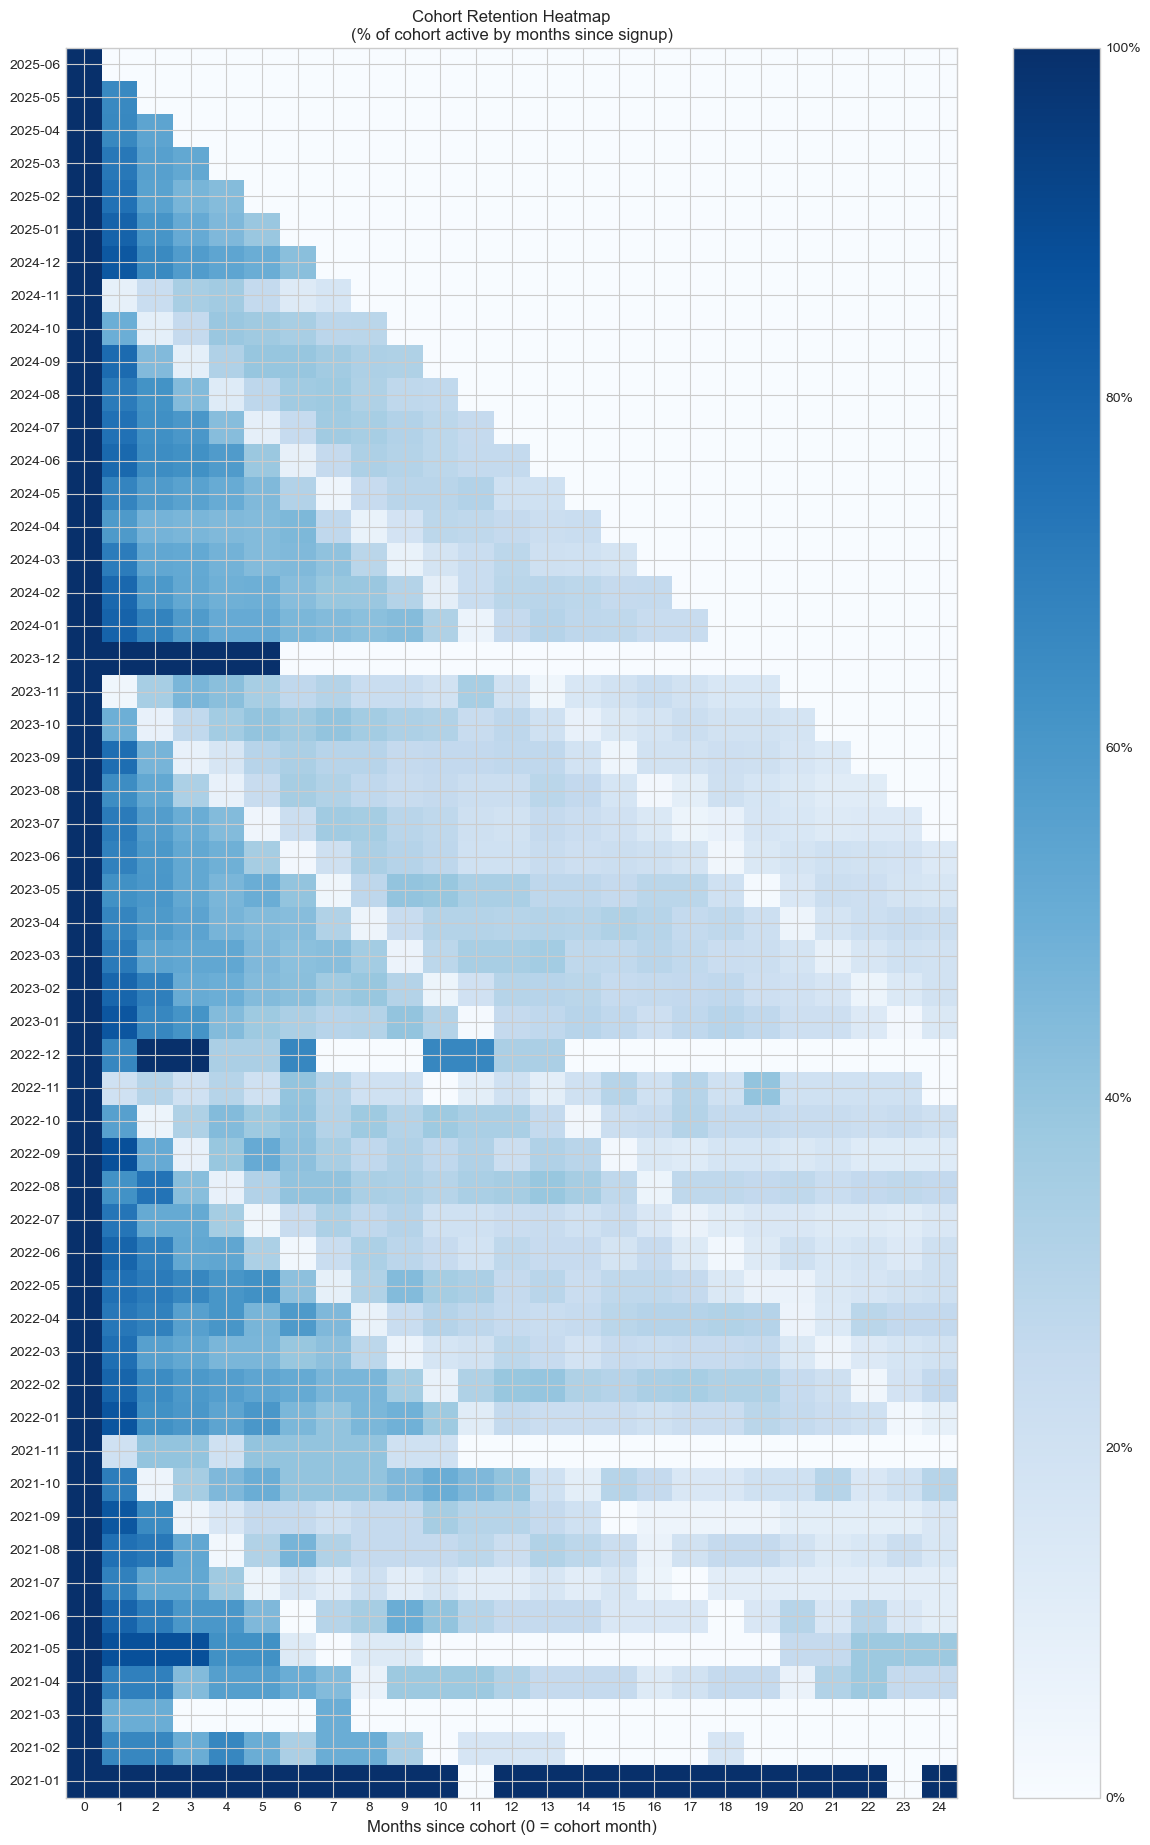

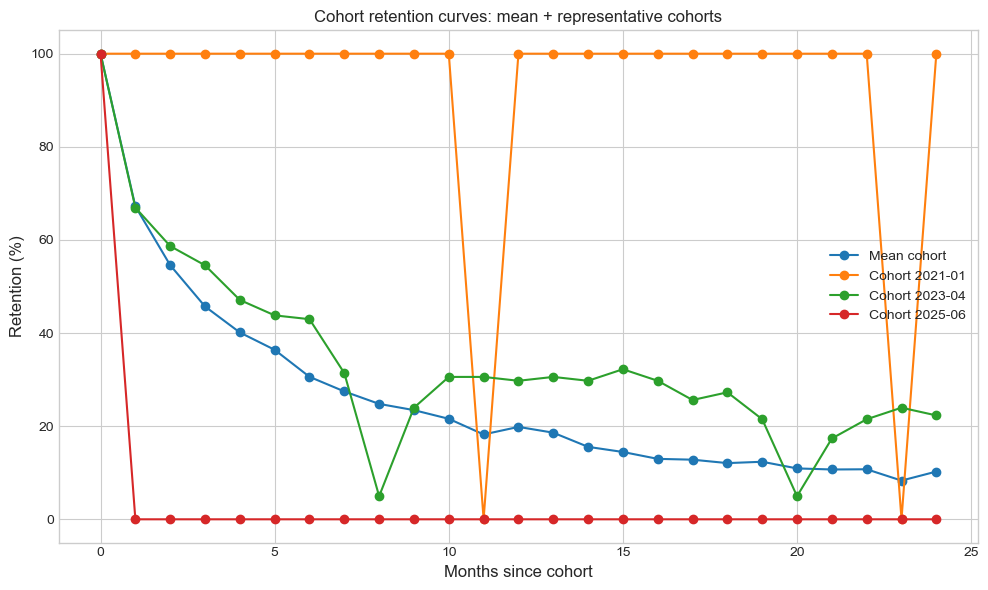


Retention summary (median / mean % across cohorts):
 Month 1: median = 71.4%, mean = 67.2%
 Month 3: median = 51.9%, mean = 45.7%
 Month 6: median = 36.6%, mean = 30.6%
 Month 12: median = 22.8%, mean = 19.8%


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker


file_path = "diligence_initech.fake_initech_worker_data.csv"  # change if needed
max_months = 24   # how many months of retention to compute (0 = cohort month)
out_csv = "cohort_retention_table.csv"



if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV not found at {file_path}. Put file in notebook folder or change file_path.")


df = pd.read_csv(file_path)
print("Loaded:", file_path, "shape:", df.shape)


if 'month' in df.columns:
    df['month_parsed'] = pd.to_datetime(df['month'], errors='coerce')
else:
   
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'at' in c.lower()]
    if date_cols:
        df['month_parsed'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        raise RuntimeError("No 'month' or date-like column found in CSV. Rename a date column to 'month' or include one.")

df = df.dropna(subset=['month_parsed']).copy()
df['month'] = df['month_parsed'].dt.to_period('M').dt.to_timestamp()  # normalized to month start


user_col = None
for candidate in ['worker_id', 'user_id', 'id']:
    if candidate in df.columns:
        user_col = candidate
        break
if user_col is None:
    raise RuntimeError("No user id column found. Expected 'worker_id' or 'user_id' (or 'id').")
print("Using user id column:", user_col)


first_active = df.groupby(user_col)['month'].min().rename('cohort_month').reset_index()
df = df.merge(first_active, on=user_col, how='left')


df['month_index'] = ((df['month'].dt.year - df['cohort_month'].dt.year) * 12 +
                     (df['month'].dt.month - df['cohort_month'].dt.month)).astype(int)
df = df[df['month_index'] >= 0].copy()  # only keep activity at/after cohort


activity = (df
            .groupby(['cohort_month', 'month_index'])[user_col]
            .nunique()
            .reset_index()
            .rename(columns={user_col: 'active_users'}))


cohort_sizes = activity[activity['month_index'] == 0][['cohort_month', 'active_users']].rename(columns={'active_users': 'cohort_size'})


activity = activity.merge(cohort_sizes, on='cohort_month', how='left')
activity['retention'] = activity['active_users'] / activity['cohort_size']


activity = activity[activity['month_index'] <= max_months].copy()
retention_matrix = (activity
                    .pivot(index='cohort_month', columns='month_index', values='retention')
                    .sort_index())


retention_pct = (retention_matrix.fillna(0) * 100).round(2)  # percentages, 2 decimals


retention_pct.to_csv(out_csv, index=True)
print("Saved cohort retention table (percent) to:", out_csv)
print("Cohorts:", len(retention_pct.index), "months tracked (cols):", len(retention_pct.columns))


fig_h, ax = plt.subplots(figsize=(12, max(4, 0.35 * len(retention_pct))))
cmap = plt.get_cmap('Blues')
im = ax.imshow(retention_pct.values, aspect='auto', cmap=cmap, origin='lower')


ax.set_xticks(np.arange(retention_pct.shape[1]))
ax.set_xticklabels([str(int(x)) for x in retention_pct.columns], rotation=0)
ax.set_xlabel("Months since cohort (0 = cohort month)")


ax.set_yticks(np.arange(retention_pct.shape[0]))
ax.set_yticklabels([d.strftime('%Y-%m') for d in retention_pct.index])

ax.set_title("Cohort Retention Heatmap\n(% of cohort active by months since signup)")


cbar = fig_h.colorbar(im, ax=ax)
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())


rows, cols = retention_pct.shape
if rows * cols <= 1000:
    for i in range(rows):
        for j in range(cols):
            val = retention_pct.iat[i, j]
            if val > 0:
                ax.text(j, i, f"{val:.0f}%", ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()


mean_retention = retention_pct.mean(axis=0)


cohort_list = list(retention_pct.index)
selected = []
if cohort_list:
    selected = [cohort_list[0], cohort_list[len(cohort_list)//2], cohort_list[-1]]
selected = sorted(set(selected))

fig_c, axc = plt.subplots(figsize=(10,6))
axc.plot(mean_retention.index, mean_retention.values, marker='o', label='Mean cohort')

for c in selected:
    series = retention_pct.loc[c].fillna(0)
    axc.plot(series.index, series.values, marker='o', label=f'Cohort {c.strftime("%Y-%m")}')

axc.set_xlabel("Months since cohort")
axc.set_ylabel("Retention (%)")
axc.set_title("Cohort retention curves: mean + representative cohorts")
axc.legend()
axc.grid(True)
plt.tight_layout()
plt.show()


summary_months = [1, 3, 6, 12]
print("\nRetention summary (median / mean % across cohorts):")
for m in summary_months:
    if m in retention_pct.columns:
        med = retention_pct[m].median()
        mean = retention_pct[m].mean()
        print(f" Month {m}: median = {med:.1f}%, mean = {mean:.1f}%")
    else:
        print(f" Month {m}: no data for month-index {m}")

Loaded: diligence_initech.fake_initech_worker_data.csv shape: (34968, 5)
Using user: worker_id revenue: revenue
Saved ARPU table to: arpu_by_cohort.csv
Saved heatmap PNG to: arpu_heatmap.png


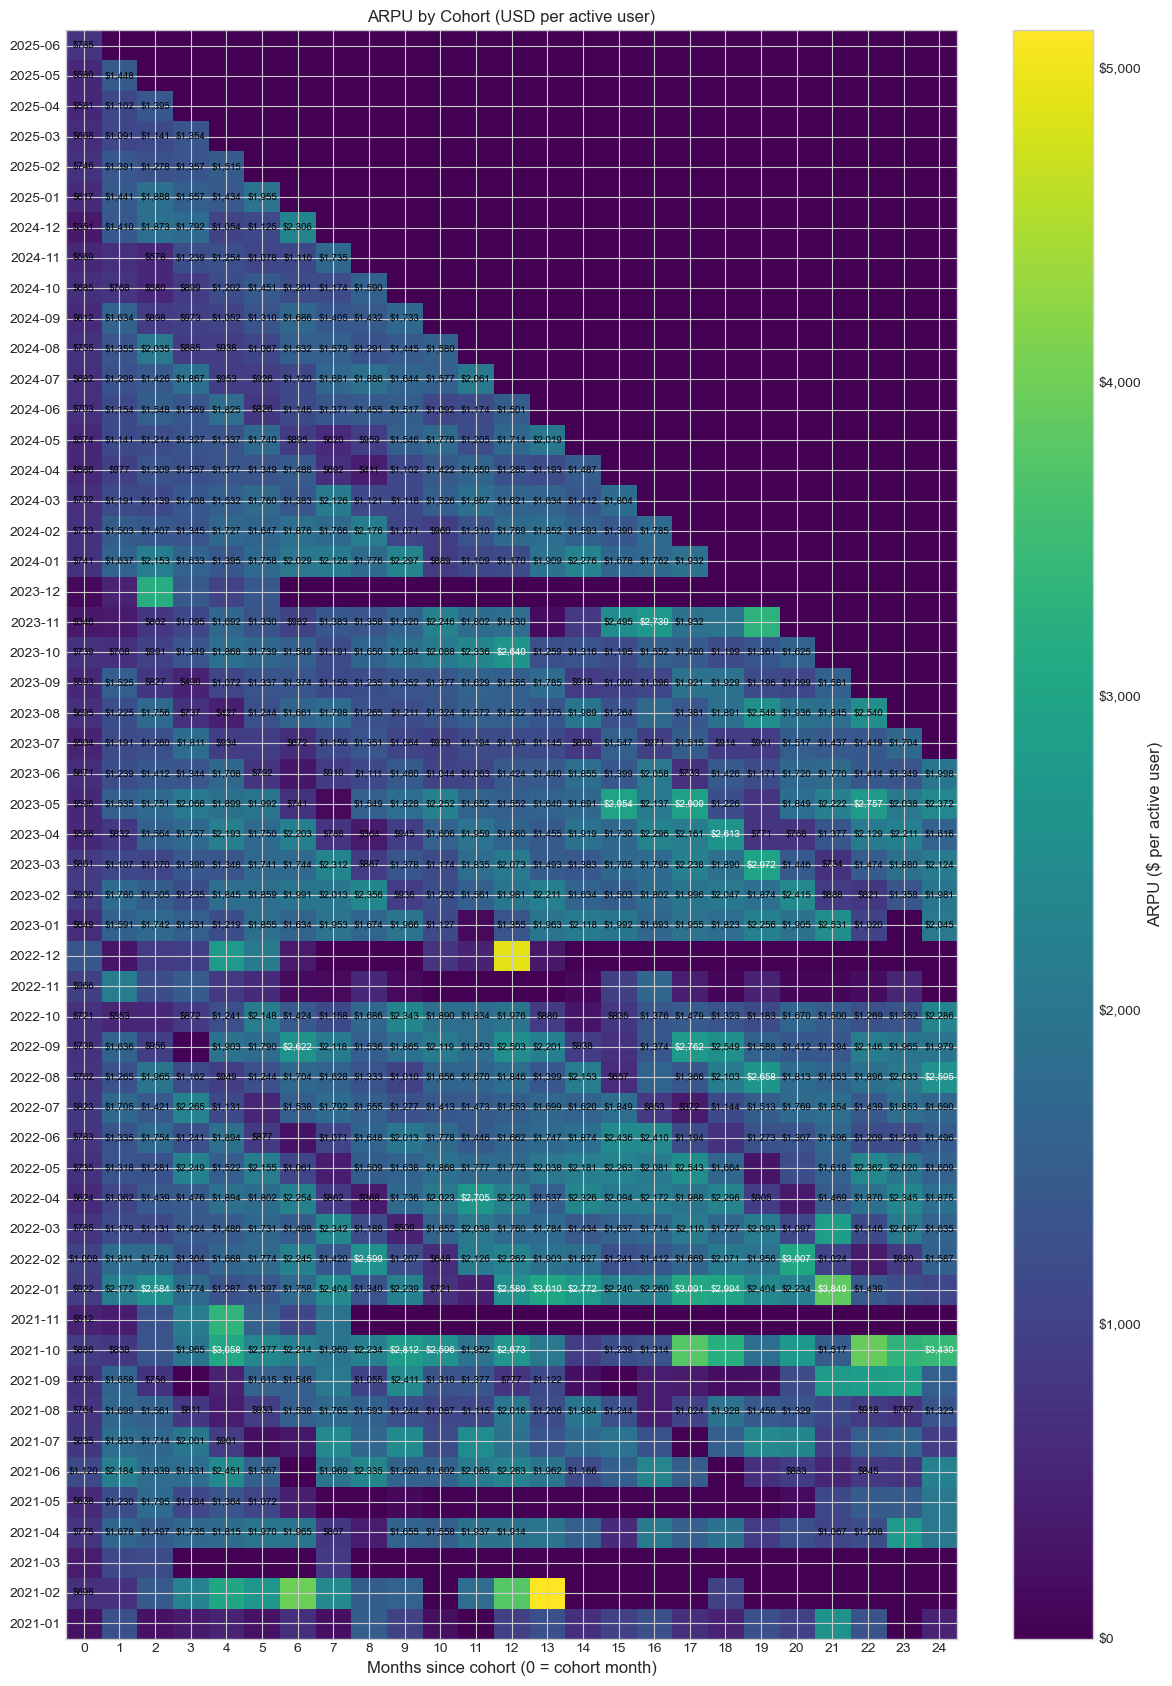

Saved curves PNG to: arpu_curves.png


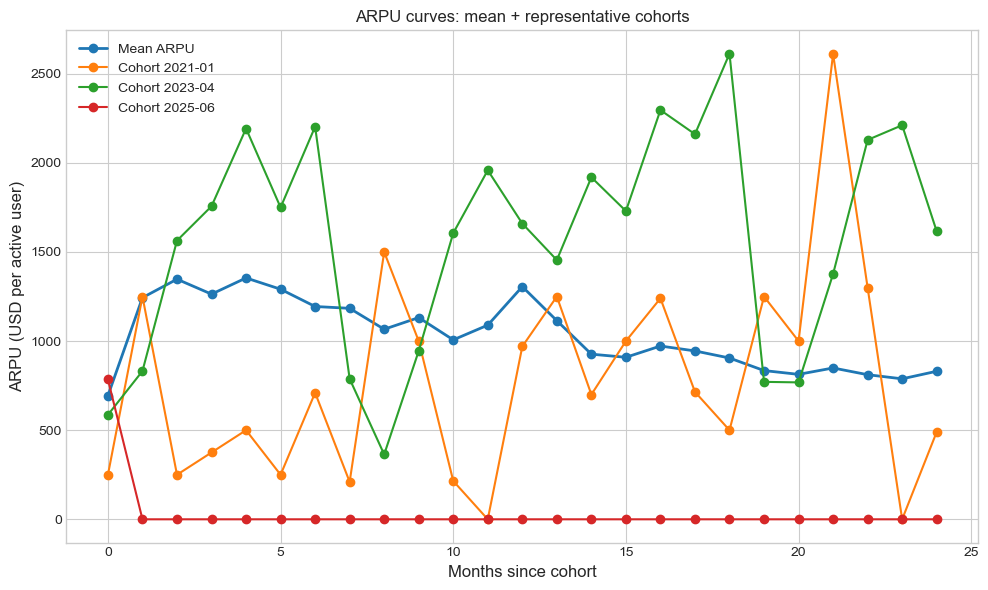


ARPU summary (median / mean in USD):
 Month 0: median = $702, mean = $694
 Month 1: median = $1,250, mean = $1,244
 Month 3: median = $1,349, mean = $1,263
 Month 6: median = $1,374, mean = $1,194
 Month 12: median = $1,552, mean = $1,306


In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker


file_path = "diligence_initech.fake_initech_worker_data.csv" 
max_months = 24  
min_active_for_label = 5  
out_csv = "arpu_by_cohort.csv"
heatmap_png = "arpu_heatmap.png"
curves_png = "arpu_curves.png"


if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV not found: {file_path}")


df = pd.read_csv(file_path)
print("Loaded:", file_path, "shape:", df.shape)


if "month" in df.columns:
    df["month_parsed"] = pd.to_datetime(df["month"], errors="coerce")
else:
    date_cols = [c for c in df.columns if "date" in c.lower() or "at" in c.lower()]
    if date_cols:
        df["month_parsed"] = pd.to_datetime(df[date_cols[0]], errors="coerce")
    else:
        raise RuntimeError("No 'month' or date-like column found. Rename one to 'month' or provide a date column.")

df = df.dropna(subset=["month_parsed"]).copy()
df["month"] = df["month_parsed"].dt.to_period("M").dt.to_timestamp()


user_col = None
for candidate in ("worker_id", "user_id", "id"):
    if candidate in df.columns:
        user_col = candidate
        break
if user_col is None:
    raise RuntimeError("No user id column found. Expected 'worker_id' or 'user_id'.")

revenue_col = None
if "revenue" in df.columns:
    revenue_col = "revenue"
else:
    candidates = [c for c in df.columns if any(x in c.lower() for x in ["amount", "pay", "price", "rev", "net_take"])]
    revenue_col = candidates[0] if candidates else None
    if revenue_col is None:
        raise RuntimeError("No revenue-like column found. Expected 'revenue' or similar.")

print("Using user:", user_col, "revenue:", revenue_col)


first_active = df.groupby(user_col)["month"].min().rename("cohort_month").reset_index()
df = df.merge(first_active, on=user_col, how="left")


df["month_index"] = ((df["month"].dt.year - df["cohort_month"].dt.year) * 12 +
                     (df["month"].dt.month - df["cohort_month"].dt.month)).astype(int)
df = df[df["month_index"] >= 0].copy()


agg = (df
       .groupby(["cohort_month", "month_index"])
       .agg(active_users=(user_col, "nunique"),
            revenue=(revenue_col, "sum"))
       .reset_index())


agg = agg[agg["month_index"] <= max_months].copy()


agg["arpu"] = agg.apply(lambda r: (r["revenue"] / r["active_users"]) if r["active_users"] and r["active_users"] > 0 else 0.0, axis=1)


arpu_matrix = agg.pivot(index="cohort_month", columns="month_index", values="arpu").sort_index()
active_matrix = agg.pivot(index="cohort_month", columns="month_index", values="active_users").sort_index()


arpu_matrix_filled = arpu_matrix.fillna(0)
active_matrix_filled = active_matrix.fillna(0)


arpu_matrix_filled.to_csv(out_csv, index=True)
print("Saved ARPU table to:", out_csv)


plt.rcParams.update({'figure.max_open_warning': 0})
fig, ax = plt.subplots(figsize=(12, max(4, 0.32 * len(arpu_matrix_filled))))
cmap = plt.get_cmap("viridis")
im = ax.imshow(arpu_matrix_filled.values, aspect="auto", origin="lower", cmap=cmap)

ax.set_xticks(np.arange(arpu_matrix_filled.shape[1]))
ax.set_xticklabels([str(int(x)) for x in arpu_matrix_filled.columns], rotation=0)
ax.set_xlabel("Months since cohort (0 = cohort month)")

ax.set_yticks(np.arange(arpu_matrix_filled.shape[0]))
ax.set_yticklabels([d.strftime("%Y-%m") for d in arpu_matrix_filled.index])

ax.set_title("ARPU by Cohort (USD per active user)")

cbar = fig.colorbar(im, ax=ax)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, p: f"${v:,.0f}"))
cbar.set_label("ARPU ($ per active user)")

rows, cols = arpu_matrix_filled.shape
if rows * cols <= 2000:  # don't annotate extremely large matrices
    for i in range(rows):
        for j in range(cols):
            active_n = int(active_matrix_filled.iat[i, j]) if not np.isnan(active_matrix_filled.iat[i, j]) else 0
            val = arpu_matrix_filled.iat[i, j]
            if active_n >= min_active_for_label and val > 0:
                ax.text(j, i, f"${val:,.0f}", ha="center", va="center", fontsize=7, color="white" if val > (arpu_matrix_filled.values.max()*0.5) else "black")

plt.tight_layout()
plt.savefig(heatmap_png, dpi=200, bbox_inches="tight")
print("Saved heatmap PNG to:", heatmap_png)
plt.show()

mean_arpu = arpu_matrix_filled.mean(axis=0)

cohort_list = list(arpu_matrix_filled.index)
selected = []
if cohort_list:
    selected = [cohort_list[0], cohort_list[len(cohort_list)//2], cohort_list[-1]]
selected = [c for c in selected if c in arpu_matrix_filled.index]

fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(mean_arpu.index, mean_arpu.values, marker="o", label="Mean ARPU", linewidth=2)

for c in selected:
    series = arpu_matrix_filled.loc[c].fillna(0)
    ax2.plot(series.index, series.values, marker="o", label=f"Cohort {c.strftime('%Y-%m')}", linewidth=1.5)

ax2.set_xlabel("Months since cohort")
ax2.set_ylabel("ARPU (USD per active user)")
ax2.set_title("ARPU curves: mean + representative cohorts")
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig(curves_png, dpi=200, bbox_inches="tight")
print("Saved curves PNG to:", curves_png)
plt.show()


summary_months = [0, 1, 3, 6, 12]
print("\nARPU summary (median / mean in USD):")
for m in summary_months:
    if m in arpu_matrix_filled.columns:
        med = arpu_matrix_filled[m].median()
        mean = arpu_matrix_filled[m].mean()
        print(f" Month {m}: median = ${med:,.0f}, mean = ${mean:,.0f}")
    else:
        print(f" Month {m}: no data")



Using CSV: ./diligence_initech.fake_initech_worker_data.csv
Loaded CSV shape: (34968, 5)
Detected columns -> user: worker_id , revenue: revenue
Using plot style: classic
Saved LTV chart to ltv_sensitivity_bar.png


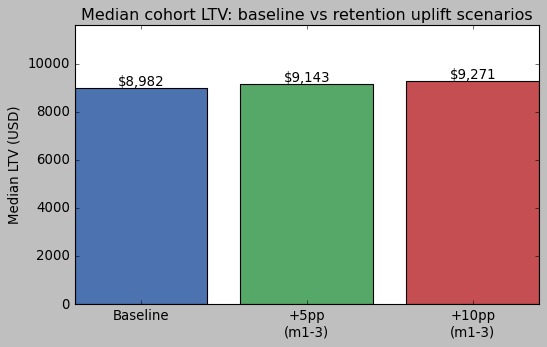

Saved contribution chart to ltv_sensitivity_contrib.png


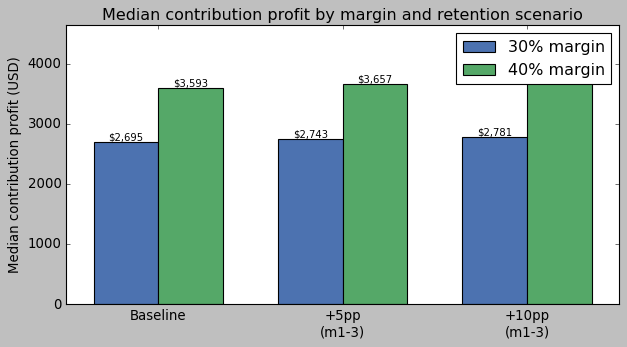

OSError: Cannot save file into a non-existent directory: '/mnt/data'

In [26]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- find CSV ----------------
candidates = [
    "/mnt/data/diligence_initech.fake_initech_worker_data.csv",
    "/mnt/data/diligence_initech.worker_data.csv",
    "/mnt/data/merged_monthly_users_revenue_v2.csv",
    "./diligence_initech.fake_initech_worker_data.csv",
    "./merged_monthly_users_revenue_v2.csv"
]

found = None
for p in candidates:
    if os.path.exists(p):
        found = p
        break

if not found:
    base = Path("/mnt/data")
    if base.exists():
        for p in base.glob("*.csv"):
            name = p.name.lower()
            if "initech" in name or "worker" in name or "merged" in name:
                found = str(p)
                break

if not found:
    try:
        csvs = list(Path("/mnt/data").glob("*.csv"))
        if csvs:
            found = str(csvs[0])
    except Exception:
        pass

if not found:
    print("No CSV found automatically. Files in /mnt/data:")
    try:
        for x in sorted(os.listdir("/mnt/data")):
            print("  ", x)
    except Exception as e:
        print("  Could not list /mnt/data:", e)
    raise FileNotFoundError("CSV not found. Upload worker CSV to /mnt/data or update candidates list.")

print("Using CSV:", found)


df = pd.read_csv(found)
print("Loaded CSV shape:", df.shape)


if 'month' in df.columns:
    df['month_parsed'] = pd.to_datetime(df['month'], errors='coerce')
else:
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'month' in c.lower() or 'at' in c.lower()]
    if date_cols:
        df['month_parsed'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        raise RuntimeError("No date-like column found in CSV. Expected 'month' or similar.")

df = df.dropna(subset=['month_parsed']).copy()
df['month'] = df['month_parsed'].dt.to_period('M').dt.to_timestamp()


user_col = None
for c in ('worker_id','user_id','id'):
    if c in df.columns:
        user_col = c
        break
if user_col is None:
    raise RuntimeError("No user id column found. Expected 'worker_id' or 'user_id'.")

revenue_col = 'revenue' if 'revenue' in df.columns else None
if revenue_col is None:
    candidates_rev = [c for c in df.columns if any(x in c.lower() for x in ['revenue','amount','pay','price','rev','net_take'])]
    revenue_col = candidates_rev[0] if candidates_rev else None
    if revenue_col is None:
        raise RuntimeError("No revenue-like column found. Expected 'revenue' or similar.")

print("Detected columns -> user:", user_col, ", revenue:", revenue_col)


first_active = df.groupby(user_col)['month'].min().rename('cohort_month').reset_index()
df = df.merge(first_active, on=user_col, how='left')
df['month_index'] = ((df['month'].dt.year - df['cohort_month'].dt.year) * 12 +
                     (df['month'].dt.month - df['cohort_month'].dt.month)).astype(int)
df = df[df['month_index'] >= 0].copy()

agg = (df.groupby(['cohort_month','month_index'])
       .agg(active_users=(user_col,'nunique'),
            revenue=(revenue_col,'sum'))
       .reset_index())
cohort_sizes = agg[agg['month_index']==0][['cohort_month','active_users']].rename(columns={'active_users':'cohort_size'})
agg = agg.merge(cohort_sizes, on='cohort_month', how='left')
agg['arpu'] = agg.apply(lambda r: (r['revenue']/r['active_users']) if r['active_users']>0 else 0.0, axis=1)

ltv_baseline = (agg.groupby('cohort_month').agg(total_revenue=('revenue','sum'),
                                               cohort_size=('cohort_size','first')).reset_index())
ltv_baseline['ltv_gross'] = ltv_baseline['total_revenue'] / ltv_baseline['cohort_size']


def simulate_uplift(agg_df, add_pp):
    df2 = agg_df.copy()
    df2['retention_frac'] = df2['active_users'] / df2['cohort_size']
    mask = df2['month_index'].isin([1,2,3])
    df2.loc[mask,'retention_frac'] = np.minimum(df2.loc[mask,'retention_frac'] + add_pp, 1.0)
    df2['active_users_sim'] = (df2['retention_frac'] * df2['cohort_size']).round(0)
    df2['revenue_sim'] = df2['arpu'] * df2['active_users_sim']
    sim = df2.groupby('cohort_month').agg(total_revenue_sim=('revenue_sim','sum'),
                                          cohort_size=('cohort_size','first')).reset_index()
    sim['ltv_gross_sim'] = sim['total_revenue_sim'] / sim['cohort_size']
    return sim[['cohort_month','ltv_gross_sim']]

sim_5pp = simulate_uplift(agg, 0.05)
sim_10pp = simulate_uplift(agg, 0.10)
ltv = ltv_baseline[['cohort_month','ltv_gross']].merge(sim_5pp, on='cohort_month').merge(sim_10pp, on='cohort_month')
ltv = ltv.rename(columns={'ltv_gross_sim_x':'ltv_5pp','ltv_gross_sim_y':'ltv_10pp'})

median_baseline = ltv['ltv_gross'].median()
median_5pp = ltv['ltv_5pp'].median()
median_10pp = ltv['ltv_10pp'].median()


m30=0.30; m40=0.40
contribs = {
    'baseline_30': median_baseline*m30, '5pp_30': median_5pp*m30, '10pp_30': median_10pp*m30,
    'baseline_40': median_baseline*m40, '5pp_40': median_5pp*m40, '10pp_40': median_10pp*m40
}


preferred_styles = ['seaborn-whitegrid', 'seaborn', 'seaborn-darkgrid', 'classic']
used_style = None
for s in preferred_styles:
    try:
        plt.style.use(s)
        used_style = s
        break
    except Exception:
        used_style = None
if used_style is None:
    # as ultimate fallback, use default rcparams
    print("No preferred styles available, using Matplotlib defaults.")
else:
    print("Using plot style:", used_style)


out_ltv = "ltv_sensitivity_bar.png"
labels = ['Baseline','+5pp\n(m1-3)','+10pp\n(m1-3)']
medians = [median_baseline, median_5pp, median_10pp]
fig, ax = plt.subplots(figsize=(7,4.5))
bars = ax.bar(labels, medians, color=['#4C72B0','#55A868','#C44E52'], edgecolor='k')
ax.set_ylabel('Median LTV (USD)')
ax.set_title('Median cohort LTV: baseline vs retention uplift scenarios')
ax.set_ylim(0, max(medians)*1.25)
for bar, val in zip(bars, medians):
    ax.text(bar.get_x()+bar.get_width()/2, val*1.01, f"${val:,.0f}", ha='center')
plt.tight_layout()
plt.savefig(out_ltv, dpi=200, bbox_inches='tight')
print("Saved LTV chart to", out_ltv)
plt.show()


out_contrib = "ltv_sensitivity_contrib.png"
x = np.arange(3); width = 0.35
fig, ax = plt.subplots(figsize=(8,4.5))
bars1 = ax.bar(x - width/2, [contribs['baseline_30'], contribs['5pp_30'], contribs['10pp_30']], width,
               label='30% margin', color='#4C72B0', edgecolor='k')
bars2 = ax.bar(x + width/2, [contribs['baseline_40'], contribs['5pp_40'], contribs['10pp_40']], width,
               label='40% margin', color='#55A868', edgecolor='k')
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel('Median contribution profit (USD)')
ax.set_title('Median contribution profit by margin and retention scenario')
ax.legend()
ax.set_ylim(0, max(contribs['baseline_40'], contribs['5pp_40'], contribs['10pp_40'])*1.25)
for b in list(bars1)+list(bars2):
    ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"${b.get_height():,.0f}", ha='center', fontsize=9)
plt.tight_layout()
plt.savefig(out_contrib, dpi=200, bbox_inches='tight')
print("Saved contribution chart to", out_contrib)
plt.show()


out_csv = "/mnt/data/ltv_sensitivity.csv"
ltv.to_csv(out_csv, index=False)
print("Saved per-cohort sensitivity table to", out_csv)


pct5 = (median_5pp/median_baseline-1)*100 if median_baseline else 0.0
pct10 = (median_10pp/median_baseline-1)*100 if median_baseline else 0.0
print(f"Median LTVs: Baseline ${median_baseline:,.0f}, +5pp ${median_5pp:,.0f} (+{pct5:.1f}%), +10pp ${median_10pp:,.0f} (+{pct10:.1f}%).")
print(f"Median contrib profit (30% margin): ${contribs['baseline_30']:,.0f} -> ${contribs['5pp_30']:,.0f} -> ${contribs['10pp_30']:,.0f}")
print(f"Median contrib profit (40% margin): ${contribs['baseline_40']:,.0f} -> ${contribs['5pp_40']:,.0f} -> ${contribs['10pp_40']:,.0f}")
